In [1]:
import os
from random import randint

import cv2
import nibabel
import nibabel as nib
import numpy as np
import torch
from matplotlib import animation
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import imageio
import os
from PIL import Image
from torchvision import transforms
import pandas as pd
import random
from scipy import ndimage
import mat73

In [5]:
ROOT_DIR = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\CancerousDataset"

In [64]:
import matplotlib.pyplot as plt

In [77]:
class AnoBratsDataset(Dataset):
    """Anomalous MRI dataset."""

    def __init__(
            self, ROOT_DIR, transform=None, img_size=(256, 256), slice_selection="random", resized=False,
            cleaned=False
            ):
        """
        Args:
            ROOT_DIR (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            img_size: size of each 2D dataset image
            slice_selection: "random" = randomly selects a slice from the image
                             "iterateKnown" = iterates between ranges of tumour using slice data
                             "iterateUnKnown" = iterates through whole MRI volume
        """
        self.transform = transforms.Compose(
                [transforms.ToPILImage(),
                 transforms.CenterCrop((175, 240)),
                 # transforms.RandomAffine(0, translate=(0.02, 0.1)),
                 transforms.Resize(img_size, transforms.InterpolationMode.BILINEAR),
                 # transforms.CenterCrop(256),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5), (0.5))
                 ]
                ) if not transform else transform
        self.img_size = img_size
        self.resized = resized
        self.slices = {
            "BraTS2021_00000": range(165, 205), "BraTS2021_00002": range(177, 213), "BraTS2021_00003": range(160, 190), "BraTS2021_00005": range(160, 212),
            "BraTS2021_00006": range(140, 200), "BraTS2021_00008": range(135, 190), "BraTS2021_00009": range(150, 205), "BraTS2021_00011": range(130, 190),
            "BraTS2021_00012": range(120, 180), "BraTS2021_00014": range(170, 194), "BraTS2021_00016": range(158, 195), "BraTS2021_00017": range(155, 195),
            "BraTS2021_00018": range(184, 213), "BraTS2021_00019": range(158, 209), "BraTS2021_00020": range(158, 210), "BraTS2021_00021": range(164, 200),
            "BraTS2021_00022": range(142, 200), "BraTS2021_00024": range(160, 200), "BraTS2021_00025": range(147, 210), "BraTS2021_00026": range(155, 200)
        }

        self.filenames = self.slices.keys()
        self.filenames = list(map(lambda name: f"{ROOT_DIR}/{name}/{name}", self.filenames))
        if ".DS_Store" in self.filenames:
            self.filenames.remove(".DS_Store")
        self.ROOT_DIR = ROOT_DIR
        self.slice_selection = slice_selection
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.filenames[idx] + "_" + "t1" + ".nii.gz"
        mask_name = self.filenames[idx] + "_" + "seg" + ".nii.gz"
        img = nib.load(img_name)
        image = img.get_fdata()
        msk = nib.load(mask_name)
        mask = msk.get_fdata()            
        image = np.rot90(image)
        image_mean = np.mean(image)
        image_std = np.std(image)
        img_range = (image_mean - 1 * image_std, image_mean + 2 * image_std)
        image = np.clip(image, img_range[0], img_range[1])
        image = image / (img_range[1] - img_range[0])
#         np.save(
#                 os.path.join(f"{self.filenames[idx]}.npy"), image.astype(
#                         np.float32
#                         )
#                 )
        sample = {}
#         if self.slice_selection == "random":
        temp_range = self.slices[self.filenames[idx].split("/")[-1]]
        slice_idx = randint(temp_range.start, temp_range.stop)
        image1 = image[slice_idx:slice_idx + 1, :, :].reshape(image.shape[1], image.shape[2]).astype(np.float32)
        mask = mask[slice_idx:slice_idx + 1, :, :].reshape(mask.shape[1], mask.shape[2]).astype(np.float32)
        if self.transform:
            image = self.transform(image)
                # image = transforms.functional.rotate(image, -90)
        sample["slices"] = slice_idx

#         elif self.slice_selection == "iterateUnknown":

#             output = torch.empty(image.shape[0], *self.img_size)
#             for i in range(image.shape[0]):
#                 temp = image[i:i + 1, :, :].reshape(image.shape[1], image.shape[2]).astype(np.float32)
#                 if self.transform:
#                     temp = self.transform(temp)
#                     # temp = transforms.functional.rotate(temp, -90)
#                 output[i, ...] = temp

#             image = output
#             sample["slices"] = image.shape[0]

        sample["image"] = image
        sample["mask"] = mask
        sample["filenames"] = self.filenames[idx].split("/")[-1]
#         sample = {'image': image, "filenames": self.filenames[idx], "mask":mask}
        return sample

In [78]:
data = AnomalousMRIDataset(ROOT_DIR)

In [72]:
data.filenames[0].split("/")

['C:\\Users\\Admin\\Dropbox\\PC\\Documents\\Anomaly Detection\\AnoDDPM\\DATASETS\\CancerousDataset',
 'BraTS2021_00000',
 'BraTS2021_00000']

In [73]:
for i in data:
    print(i['image'].shape)

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


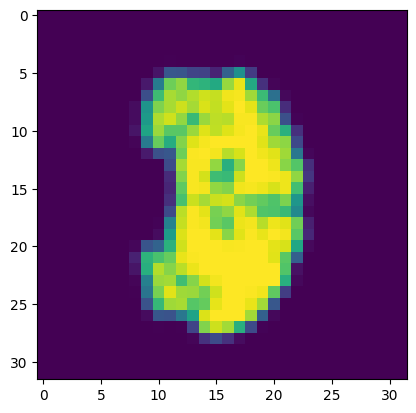

In [81]:
plt.imshow(i['image'][0])

In [79]:
for i in data:
    print(i['mask'].shape)

(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)
(240, 155)


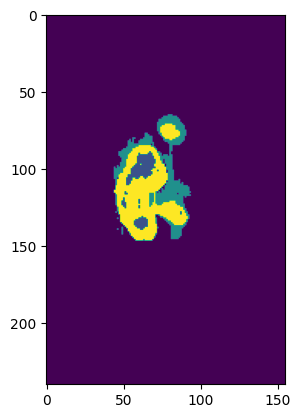

In [80]:
plt.imshow(i['mask'])